# Generated Vs. Real Image Classification

By: Joe Sellett, Haiyan Cai, and Cole Wagner

## Data Preparation

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from statsmodels.stats.contingency_tables import mcnemar
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    Activation,
    Add,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
    RandomContrast,
    RandomRotation,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import image_dataset_from_directory

tf.config.list_physical_devices("GPU")

[]

### Load Data

In [2]:
train_img, test_img = image_dataset_from_directory(
    directory="images",
    label_mode="binary",
    image_size=(32, 32),
    seed=7324,
    validation_split=0.2,
    subset="both",
)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


### Data Splitting Justification

We decided to use an 80/20 train/test split for our dataset. We chose a split over cross-validation because we have more than enough data (100,000 images) to train our model effectively while also reserving a significant portion for testing. This technique more closely mimics how the model would be used in a real-world scenario, because it is predicting completely unseen data. Typically, cross-validation is reserved for smaller datasets, where the model needs to be trained on the whole dataset to generalize well. This is not the case for our dataset, and cross-validation would significantly increase the time it would take to train our model.

### Performance Metrics Justification

While we will consider a suite of metrics to evaluate our model, we will focus on ROC AUC as our primary metric. This is because it provides a comprehensive view of the model's performance. We will also consider accuracy, precision, and recall to provide additional context and understanding of the model's performance. We opted for AUC as our primary metric over precision and recall (which measure a model's aptitude for false positives and false negatives) because we are more interested in the model's overall ability to distinguish between real and generated images, rather than its performance for a specific class. This is because any business use cases would most likely consider false predictions for both classes equally bad, and we want to ensure that the model is robust across both classes.

## Modeling

### Data Augmentation Justification

We will use both `RandomContrast` and `RandomRotation` augmentation techniques. Because we have color images, we want to ensure that our model is robust to changes in color and brightness (thus, `RandomContrast`). We also want to ensure that our model is robust to changes in orientation, as this can significantly impact the model's performance (thus, `RandomRotation`). This way, we have one color augmentation and one position augmentation, which will help our model generalize better to unseen data.

### Model Architecture 1

We start with a simple sequential CNN model with two convulutional layers followed by a max pooling layer. We then flatten the output and pass it through one dense hidden layer before the output layer. We also include some dropout to prevent overfitting. This model is a good starting point for our problem, as it is simple and easy to interpret.

In [3]:
cnn1 = Sequential()
# Data augmentation
cnn1.add(RandomContrast(factor=0.5, seed=7324))
cnn1.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn1.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
    ),
)
cnn1.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
    ),
)
cnn1.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn1.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn1.add(Flatten())
# Fully connected layers
cnn1.add(Dense(64, activation="relu"))
# Add some dropout for regularization
cnn1.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn1.add(Dense(1, activation="sigmoid"))

In [4]:
cnn1.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [5]:
# cnn1_history = cnn1.fit(
#     train_img,
#     epochs=10,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/cnn1_history.pickle", "rb") as handle:
    cnn1_history = pickle.load(handle)


In [6]:
def plot_metrics(history_obj: tf.keras.callbacks.History) -> None:
    """Plot all metrics in the model history.

    Parameters
    ----------
    history_obj : History
        The history object returned by the fit method of the model.

    """
    metrics = [
        key for key in history_obj.history if not key.startswith("val_")
    ]
    num_metrics = len(metrics)
    plt.figure(figsize=(15, 5 * ((num_metrics + 1) // 2)))

    for i, metric in enumerate(metrics, 1):
        plt.subplot((num_metrics + 1) // 2, 2, i)
        plt.plot(history_obj.history[metric], label="training")
        plt.plot(history_obj.history[f"val_{metric}"], label="validation")
        plt.title(metric.capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()


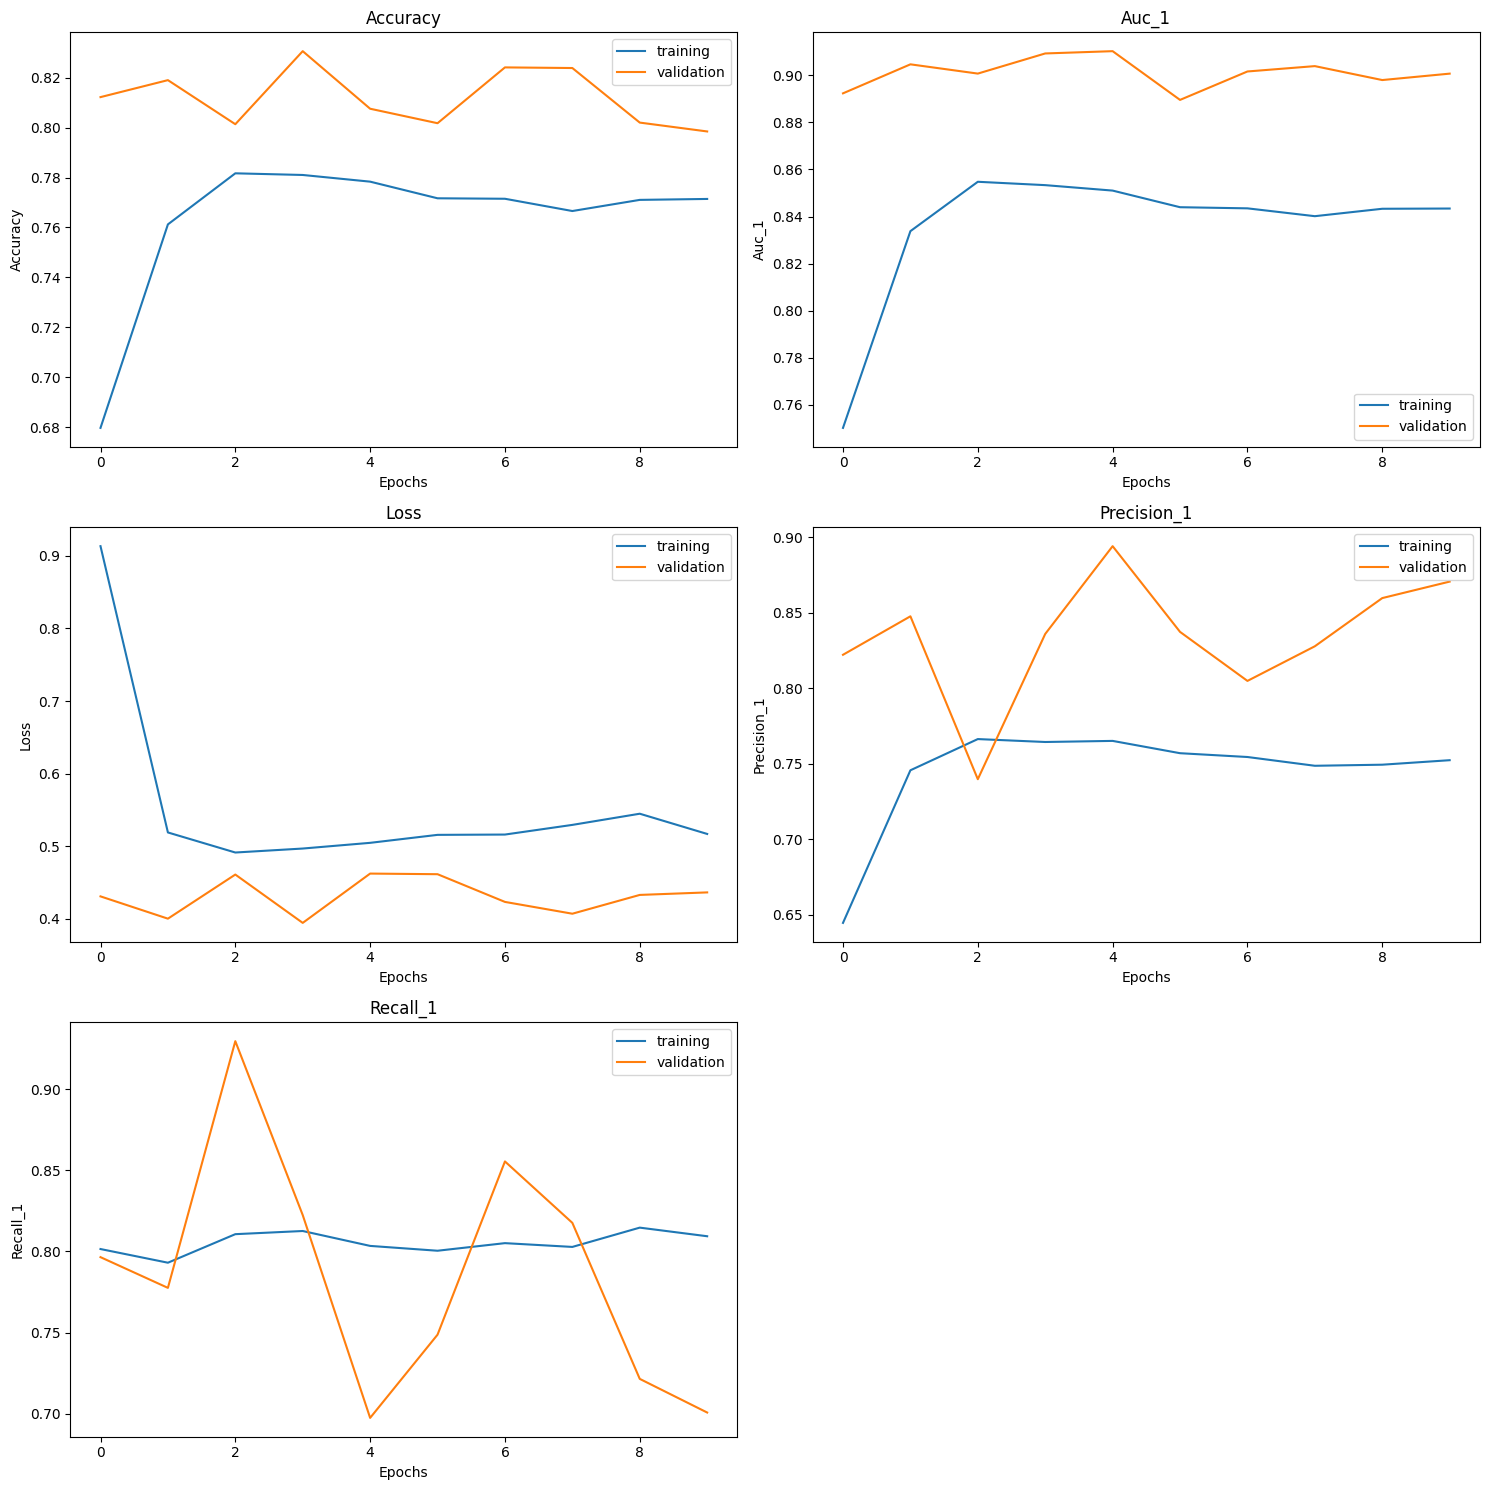

In [7]:
plot_metrics(cnn1_history)

From the plots above, we can see that our model converges quickly and then plateaus. We want to try to squeeze out a little more performance from our model, so we will make two adjustments:
1. Reduce the kernel size to 2x2 due to our small image size.
2. Increase the number of neurons in our one hidden layer to 128.

In [8]:
# cnn1.save("models/cnn1.keras")
# with Path.open("histories/cnn1_history.pickle", "wb") as handle:
#     pickle.dump(cnn1_history, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [9]:
cnn2 = Sequential()
# Data augmentation
cnn2.add(RandomContrast(factor=0.5, seed=7324))
cnn2.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn2.add(
    Conv2D(
        filters=32,
        kernel_size=(2, 2),
        activation="relu",
        padding="same",
    ),
)
cnn2.add(
    Conv2D(
        filters=64,
        kernel_size=(2, 2),
        padding="same",
        activation="relu",
    ),
)
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn2.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn2.add(Flatten())
# Fully connected layers
cnn2.add(Dense(128, activation="relu"))
# Add some dropout for regularization
cnn2.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn2.add(Dense(1, activation="sigmoid"))

In [10]:
cnn2.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [11]:
# cnn2_history = cnn2.fit(
#     train_img,
#     epochs=10,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/cnn2_history.pickle", "rb") as handle:
    cnn2_history = pickle.load(handle)

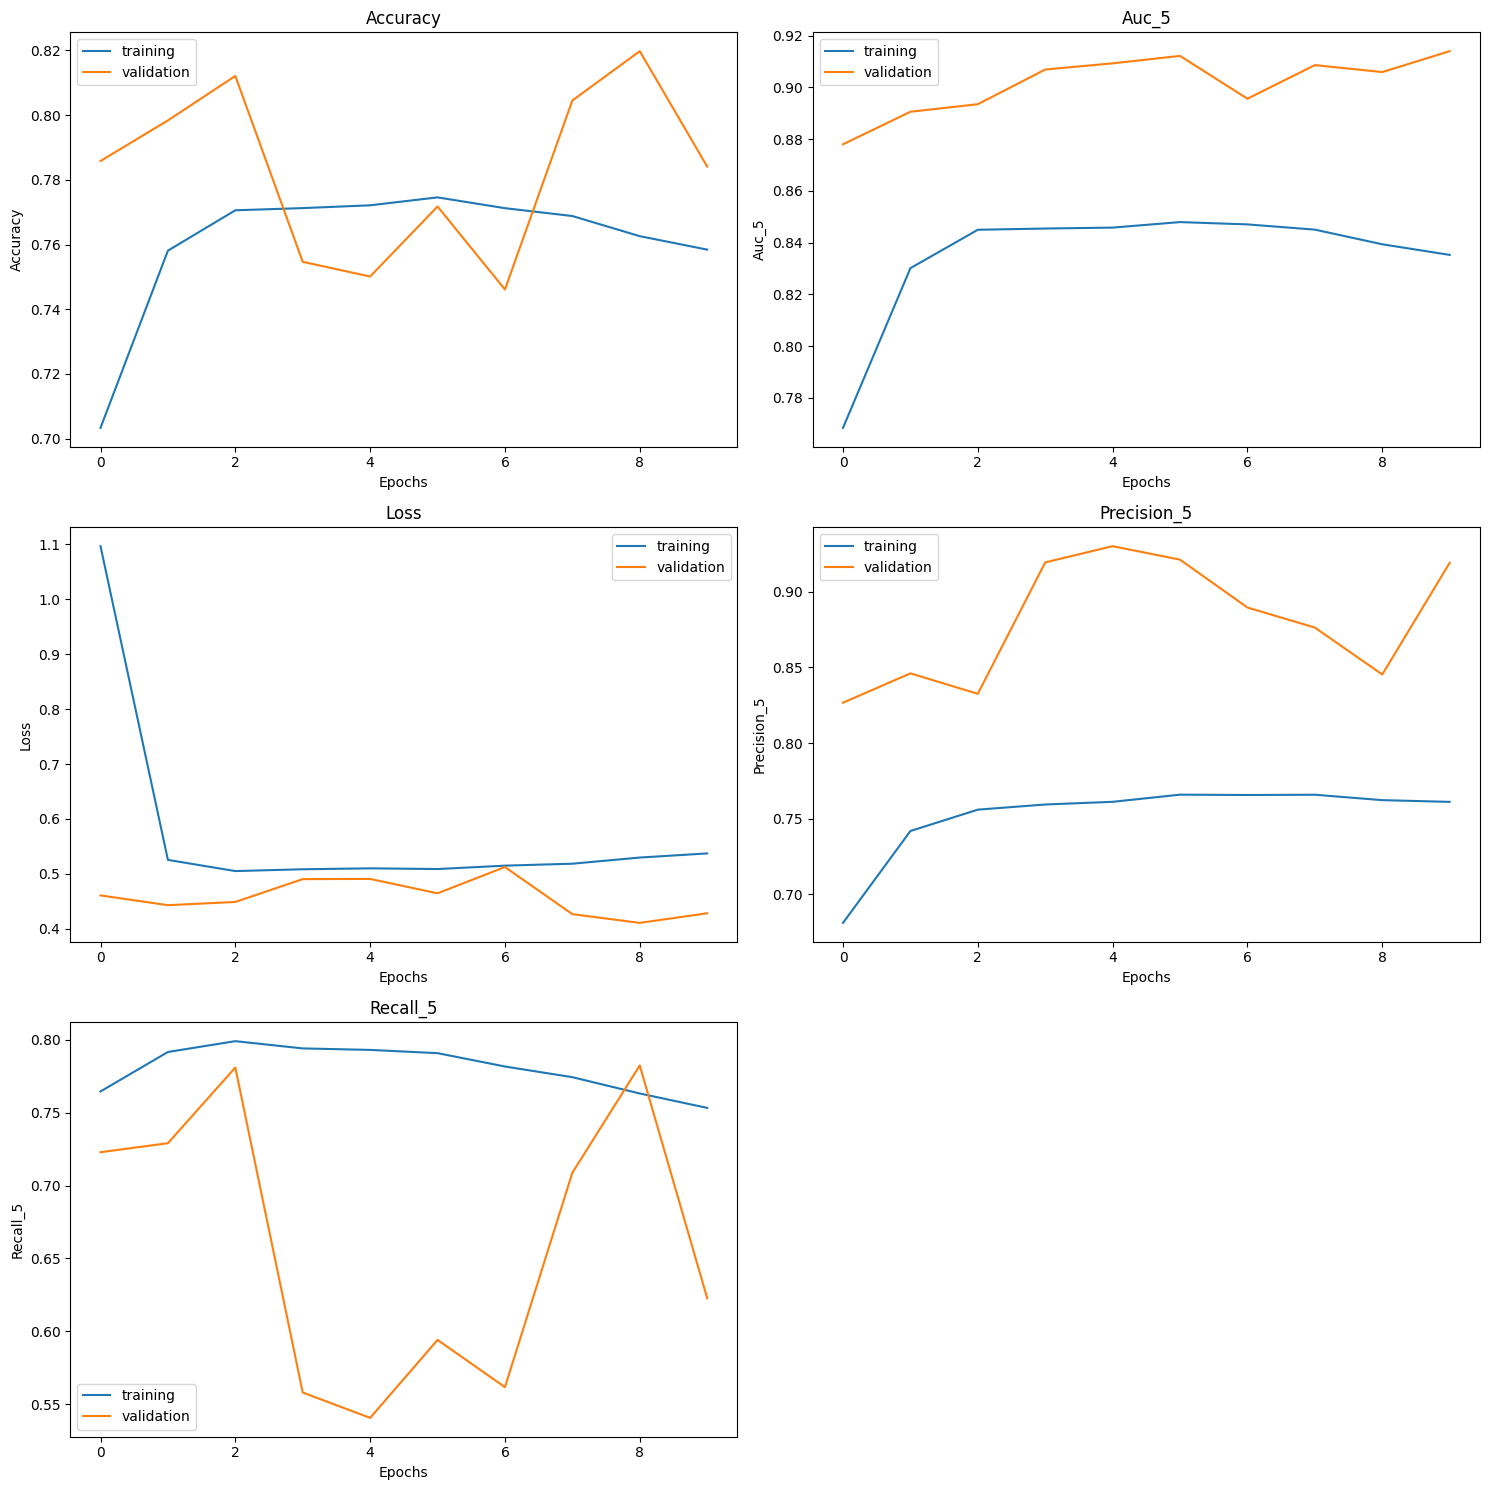

In [12]:
plot_metrics(cnn2_history)

These plots show a very similar trend to the previous model, indicating our changes had little impact on the model's performance. We will try one more adjustment to see if we can improve our model's performance:
1. Use varying kernel sizes for each convolutional layer (1x1, then 3x3).

In [13]:
# cnn2.save("models/cnn2.keras")
# with Path.open("histories/cnn2_history.pickle", "wb") as handle:
#     pickle.dump(cnn2_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
cnn3 = Sequential()
# Data augmentation
cnn3.add(RandomContrast(factor=0.5, seed=7324))
cnn3.add(RandomRotation(factor=0.5, seed=7324))

# Convolutional layers
cnn3.add(
    Conv2D(
        filters=32,
        kernel_size=(1, 1),
        activation="relu",
        padding="same",
    ),
)
cnn3.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
    ),
)
cnn3.add(MaxPooling2D(pool_size=(2, 2)))

# Add some dropout for regularization
cnn3.add(Dropout(0.5))
# Flatten the output of the convolutional layers
cnn3.add(Flatten())
# Fully connected layers
cnn3.add(Dense(128, activation="relu"))
# Add some dropout for regularization
cnn3.add(Dropout(0.5))
# Output layer sigmoid for binary classification
cnn3.add(Dense(1, activation="sigmoid"))

In [15]:
cnn3.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [16]:
# cnn3_history = cnn3.fit(
#     train_img,
#     epochs=10,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/cnn3_history.pickle", "rb") as handle:
    cnn3_history = pickle.load(handle)

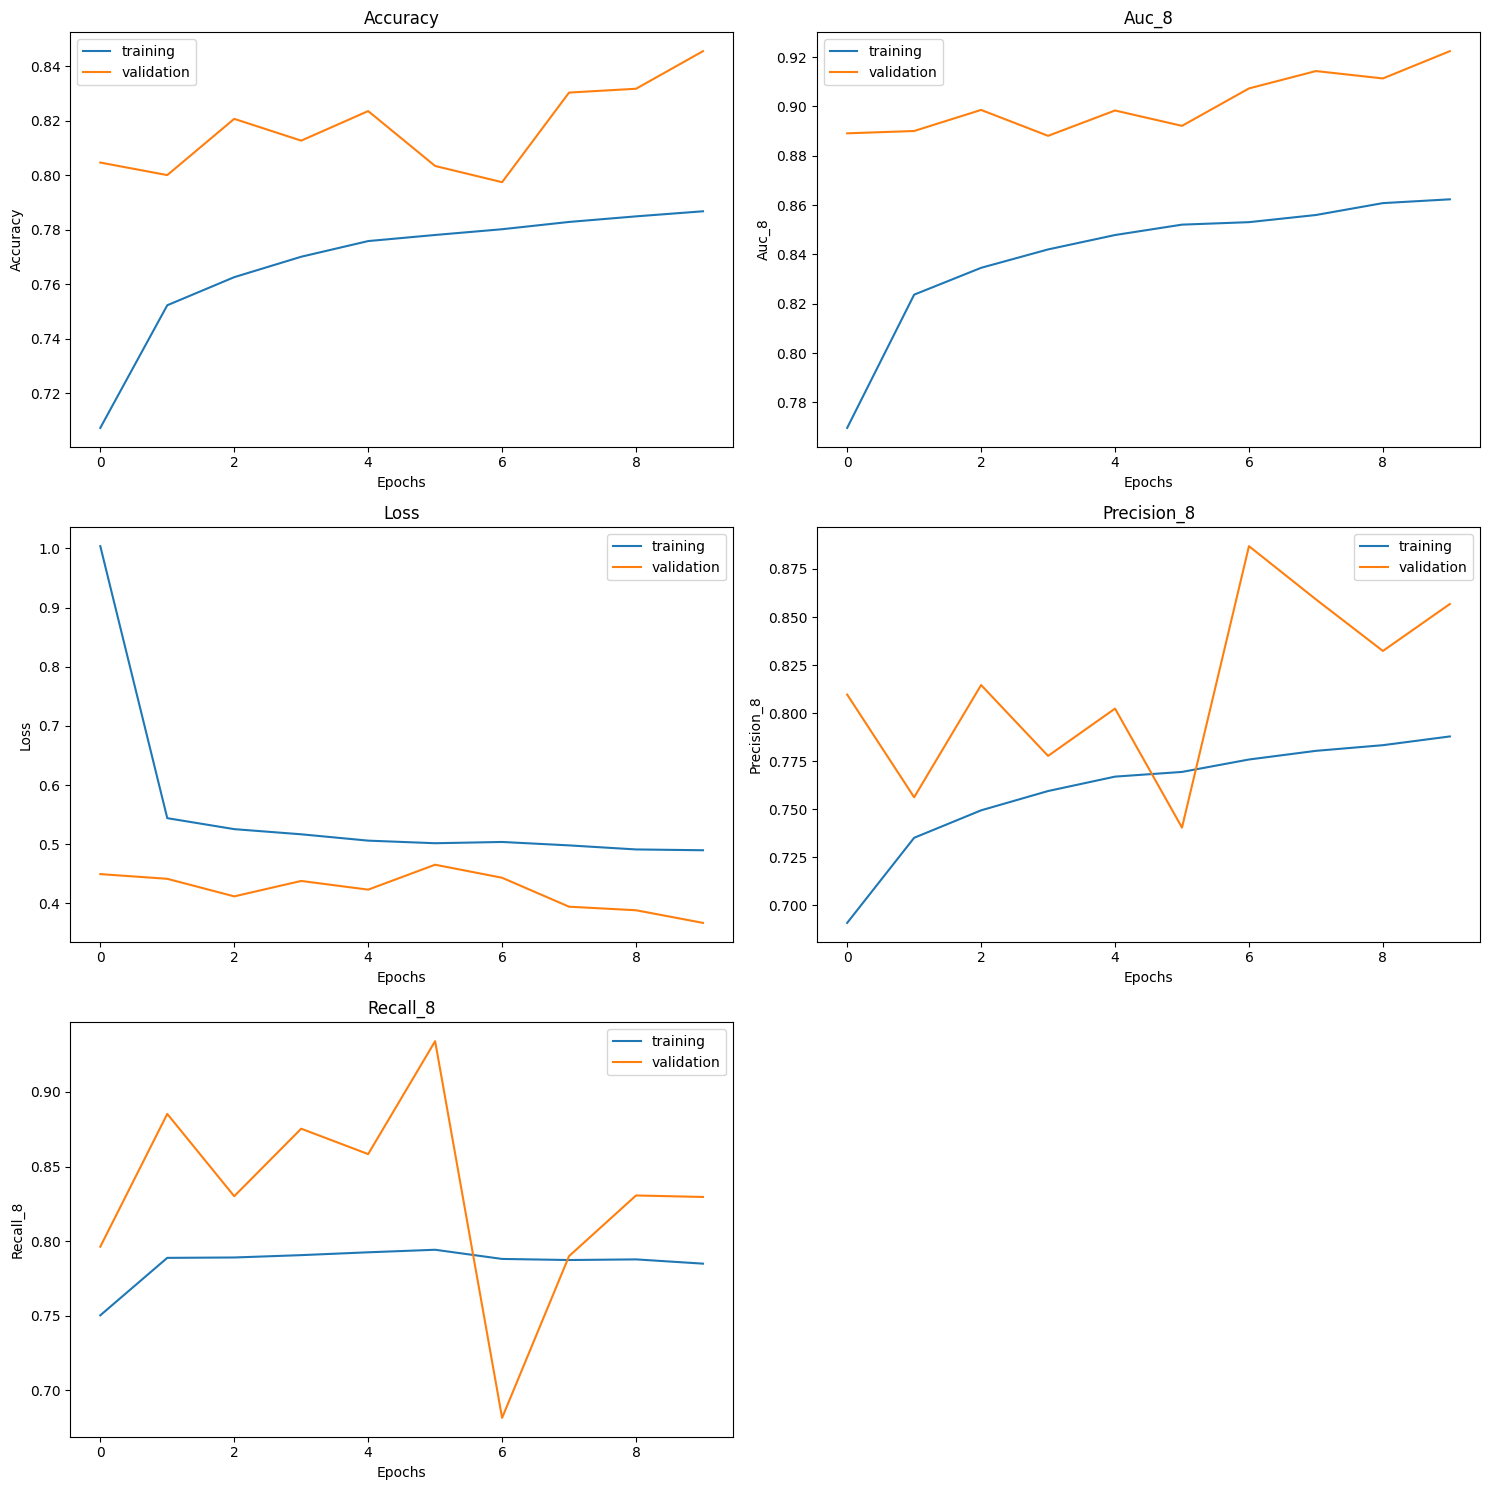

In [17]:
plot_metrics(cnn3_history)

This model is more encouraging than the previous two, as it shows a more gradual increase in performance over time rather than a quick plateau. This model is a good starting point for our problem.

In [18]:
# cnn3.save("models/cnn3.keras")
# with Path.open("histories/cnn3_history.pickle", "wb") as handle:
#     pickle.dump(cnn3_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Model Architecture 2

For our second model, we will use a ResNet style architecture with a bypass layer to try to further improve our model's performance. This architecture is more complex than the previous model, but it has been shown to be effective for image classification tasks.

In [19]:
input_holder = Input(shape=(32, 32, 3))

# Data augmentation
x = RandomContrast(factor=0.5, seed=7324)(input_holder)
x = RandomRotation(factor=0.5, seed=7324)(x)

# start with a conv layer
x = Conv2D(
    filters=32,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x_split = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x_split)

x = Conv2D(
    filters=64,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x = Conv2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x)

# Add split back in
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation("sigmoid")(x)

resnet1 = Model(inputs=input_holder, outputs=x)

In [20]:
resnet1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [21]:
# resnet1_history = resnet1.fit(
#     train_img,
#     batch_size=32,
#     epochs=10,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/resnet1_history.pickle", "rb") as handle:
    resnet1_history = pickle.load(handle)

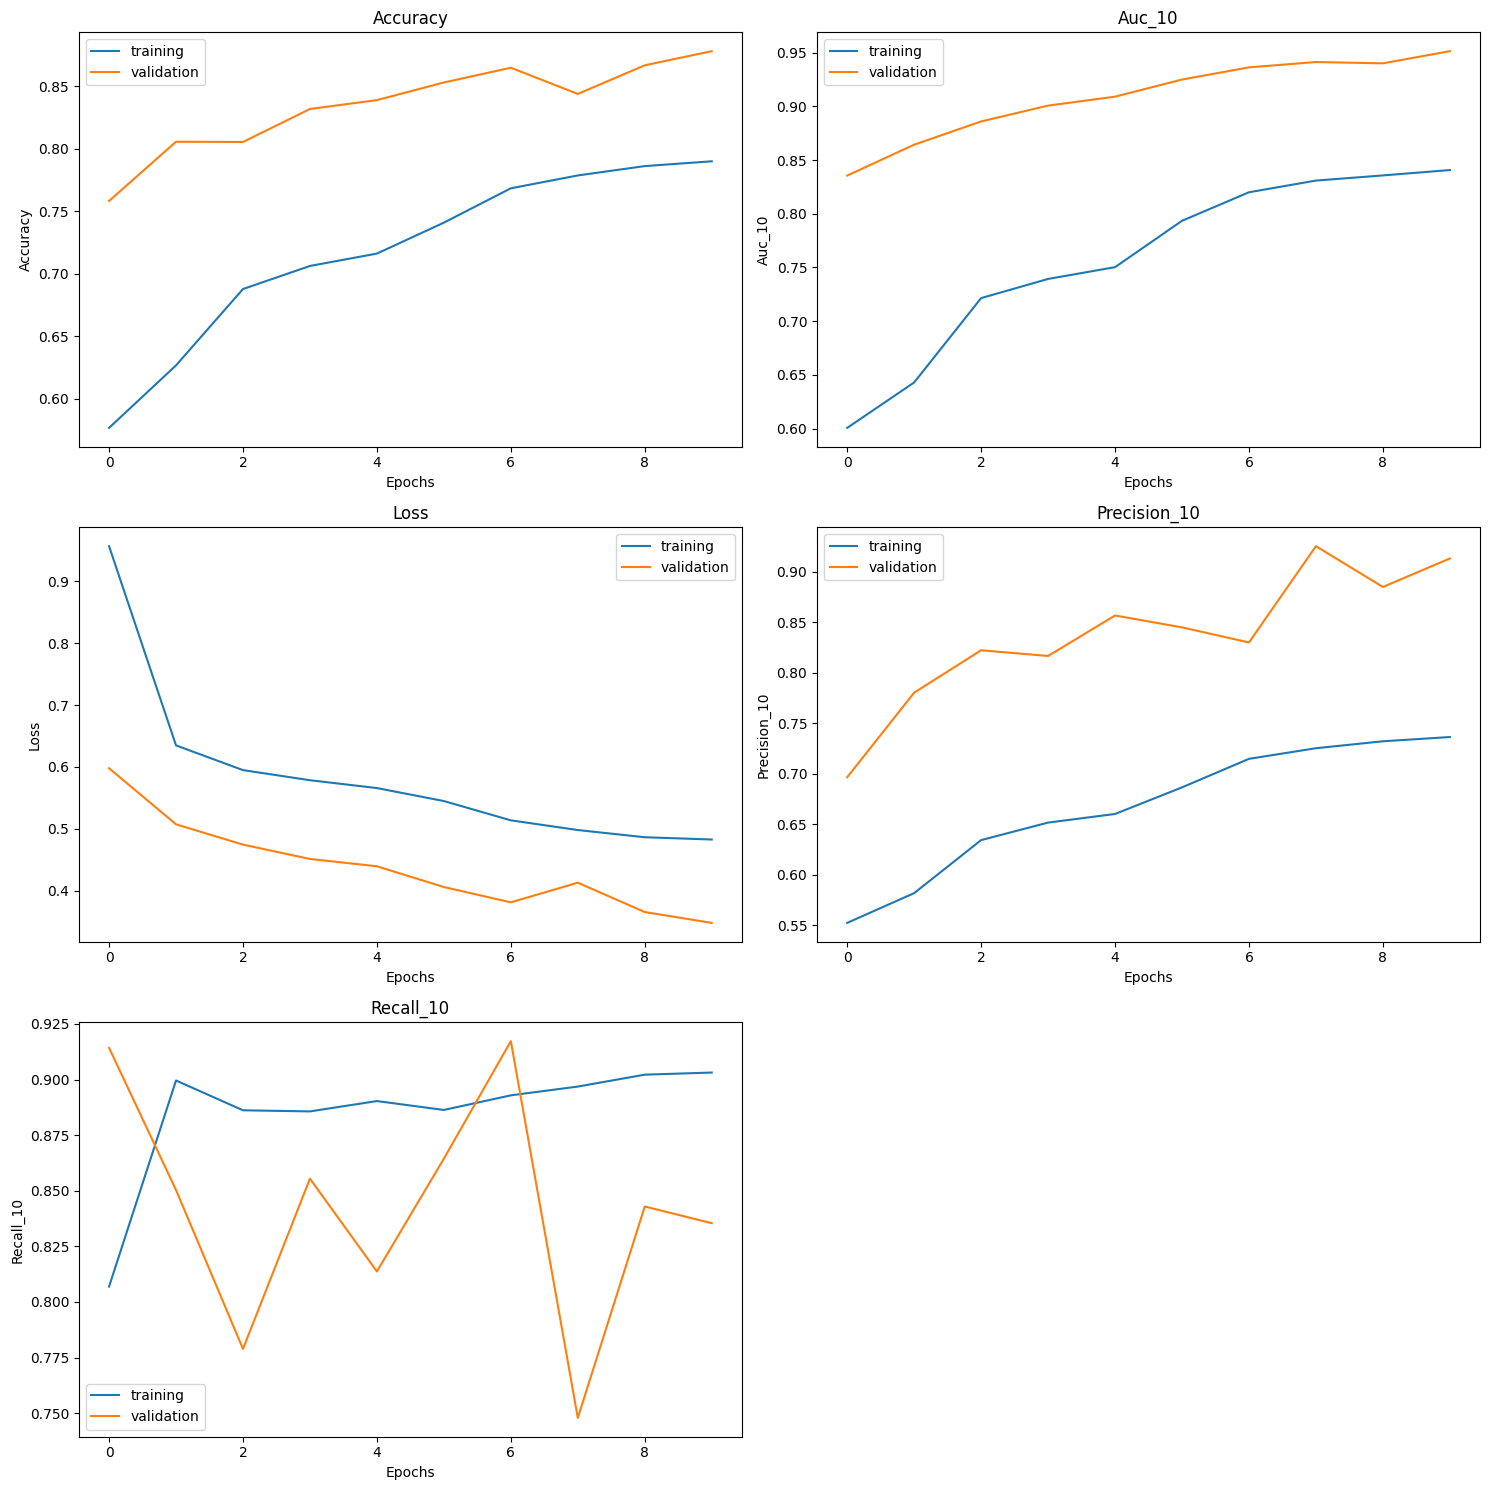

In [22]:
plot_metrics(resnet1_history)

Here we see a significant improvement in model performance when compared to the purely sequential model. There is a steady increase in performance over time, and the model is able to achieve a higher AUC than the previous model. Since we are already very happy with this model's performance, we will only make one more adjustment:
1. Increase the number of neurons in our one hidden layer to 256.

In [23]:
# resnet1.save("models/resnet1.keras")
# with Path.open("histories/resnet1_history.pickle", "wb") as handle:
#     pickle.dump(resnet1_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
input_holder = Input(shape=(32, 32, 3))

# Data augmentation
x = RandomContrast(factor=0.5, seed=7324)(input_holder)
x = RandomRotation(factor=0.5, seed=7324)(x)

# start with a conv layer
x = Conv2D(
    filters=32,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x_split = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x_split)

x = Conv2D(
    filters=32,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)

x = Conv2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    activation="relu",
)(x)

# Add split back in
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation("sigmoid")(x)

resnet2 = Model(inputs=input_holder, outputs=x)

In [25]:
resnet2.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [26]:
# resnet2_history = resnet2.fit(
#     train_img,
#     batch_size=32,
#     epochs=10,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/resnet2_history.pickle", "rb") as handle:
    resnet2_history = pickle.load(handle)

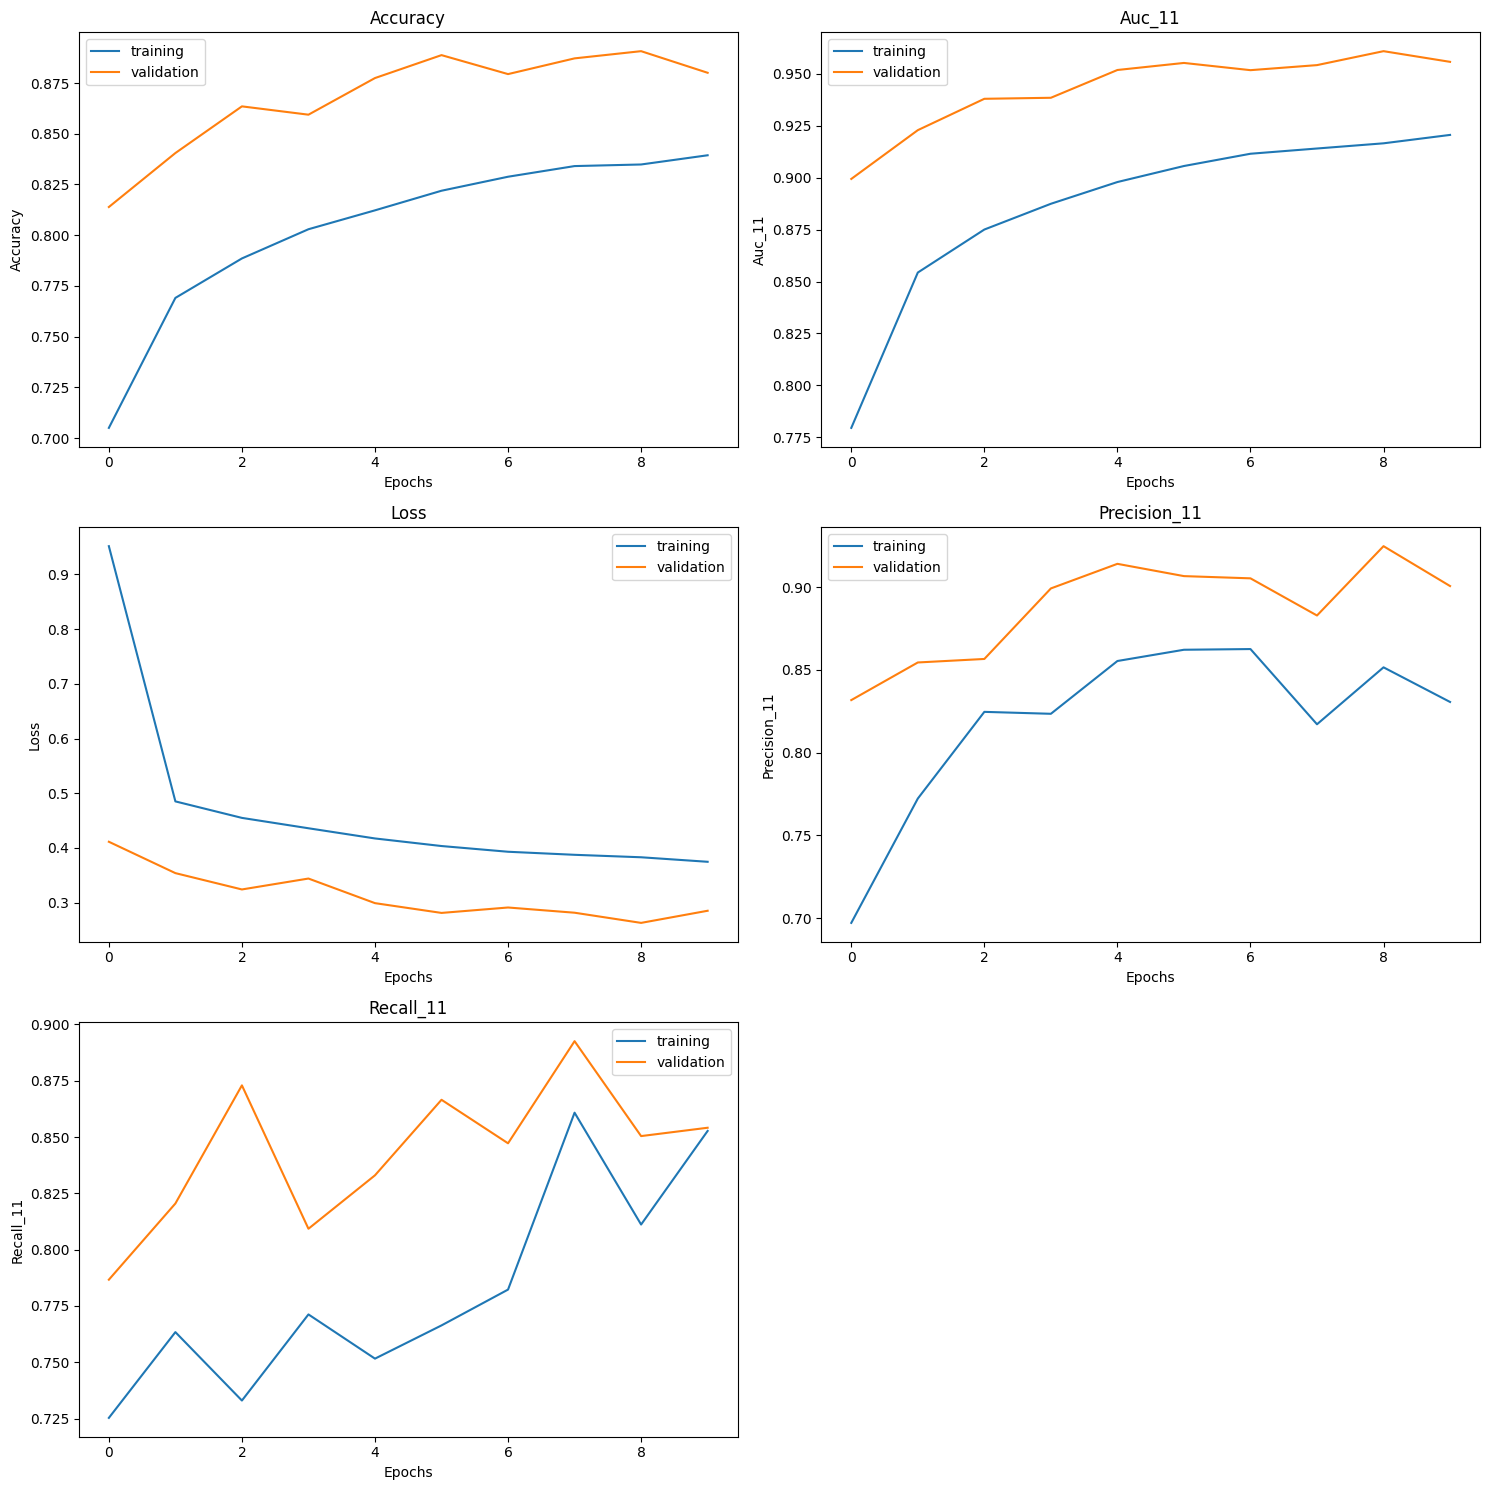

In [27]:
plot_metrics(resnet2_history)

This model shows the best performance so far, achieving an AUC of >0.95. We are very happy with this model's performance, and we will use it as our final model.

In [28]:
# resnet2.save("models/resnet2.keras")
# with Path.open("histories/resnet2_history.pickle", "wb") as handle:
#     pickle.dump(resnet2_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Model Comparison

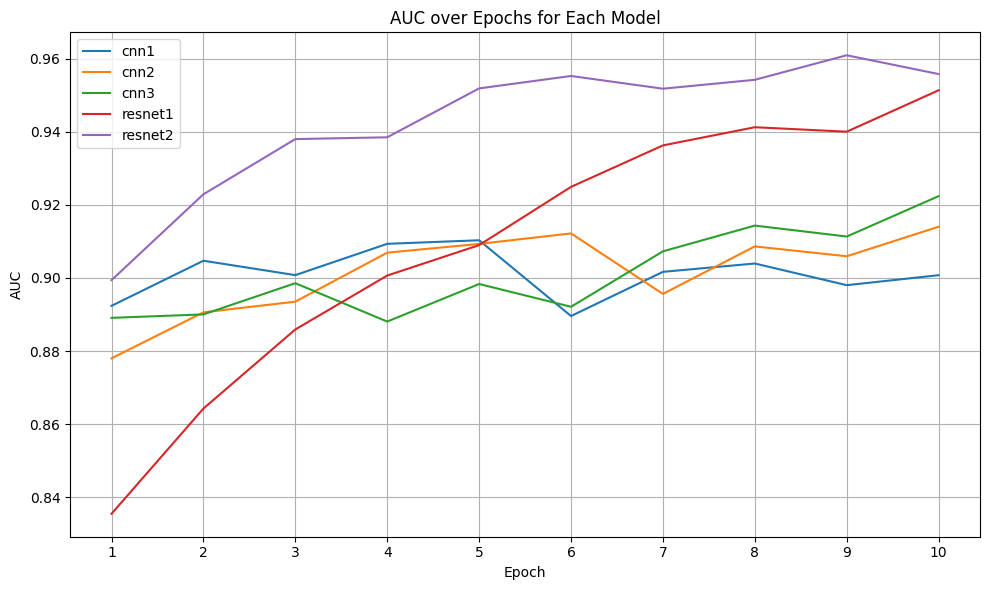

In [29]:
plt.figure(figsize=(10, 6))

auc_histories = {
    "cnn1": next(
        value
        for key, value in cnn1_history.history.items()
        if key.startswith("val_auc")
    ),
    "cnn2": next(
        value
        for key, value in cnn2_history.history.items()
        if key.startswith("val_auc")
    ),
    "cnn3": next(
        value
        for key, value in cnn3_history.history.items()
        if key.startswith("val_auc")
    ),
    "resnet1": next(
        value
        for key, value in resnet1_history.history.items()
        if key.startswith("val_auc")
    ),
    "resnet2": next(
        value
        for key, value in resnet2_history.history.items()
        if key.startswith("val_auc")
    ),
}

for model_name, auc_values in auc_histories.items():
    plt.plot(range(1, len(auc_values) + 1), auc_values, label=model_name)

plt.title("AUC over Epochs for Each Model")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This plot further confirms our previous findings that the ResNet style architecture is more effective than the purely sequential model. The ResNet model achieves a higher AUC and has a more gradual increase in performance over time.

In [30]:
def mcnemar_test(model1: keras.Model, model2: keras.Model) -> None:
    """Perform McNemar's test to compare two models.

    Parameters
    ----------
    model1 : keras.Model
        The first Keras model to compare.
    model2 : keras.Model
        The second Keras model to compare.

    Returns
    -------
    None
        Prints the results of the McNemar's test.

    """
    yhat1_proba = model1.predict(test_img)
    yhat1 = np.where(yhat1_proba > 0.5, 1, 0).ravel()

    yhat2_proba = model2.predict(test_img)
    yhat2 = np.where(yhat2_proba > 0.5, 1, 0).ravel()

    # Create a contingency table
    contingency_table = pd.crosstab(
        pd.Series(yhat1, name="Model 1"),
        pd.Series(yhat2, name="Model 2"),
    )

    # Perform McNemar's test
    result = mcnemar(contingency_table, exact=True)

    print("McNemar's Test Results:")
    print(f"Statistic: {result.statistic}")
    print(f"P-value: {result.pvalue}")

In [31]:
mcnemar_test(cnn1, cnn2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
McNemar's Test Results:
Statistic: 1619.0
P-value: 0.0


In [32]:
mcnemar_test(cnn2, cnn3)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
McNemar's Test Results:
Statistic: 69.0
P-value: 0.0


In [33]:
mcnemar_test(cnn3, resnet1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
McNemar's Test Results:
Statistic: 64.0
P-value: 0.0


In [34]:
mcnemar_test(resnet1, resnet2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
McNemar's Test Results:
Statistic: 4374.0
P-value: 1.8985152373160265e-06


The results of these McNemar's tests show that each step up in complexity results in a significantly different model. This is consistent with our previous findings, as we observed an increase in model performance with each adjustment we made.

### CNN vs. MLP

In [35]:
mlp = Sequential()
mlp.add(Input(shape=(32, 32, 3)))
mlp.add(RandomContrast(factor=0.5, seed=7324))
mlp.add(RandomRotation(factor=0.5, seed=7324))
mlp.add(Flatten())
mlp.add(Dense(256, activation="relu"))
mlp.add(Dense(128, activation="relu"))
mlp.add(Dense(64, activation="relu"))
mlp.add(Dense(32, activation="relu"))
mlp.add(Dense(1, activation="sigmoid"))

In [36]:
mlp.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [37]:
# mlp_history = mlp.fit(
#     train_img,
#     epochs=10,
#     verbose=1,
#     validation_data=test_img,
# )
with Path.open("histories/mlp_history.pickle", "rb") as handle:
    mlp_history = pickle.load(handle)

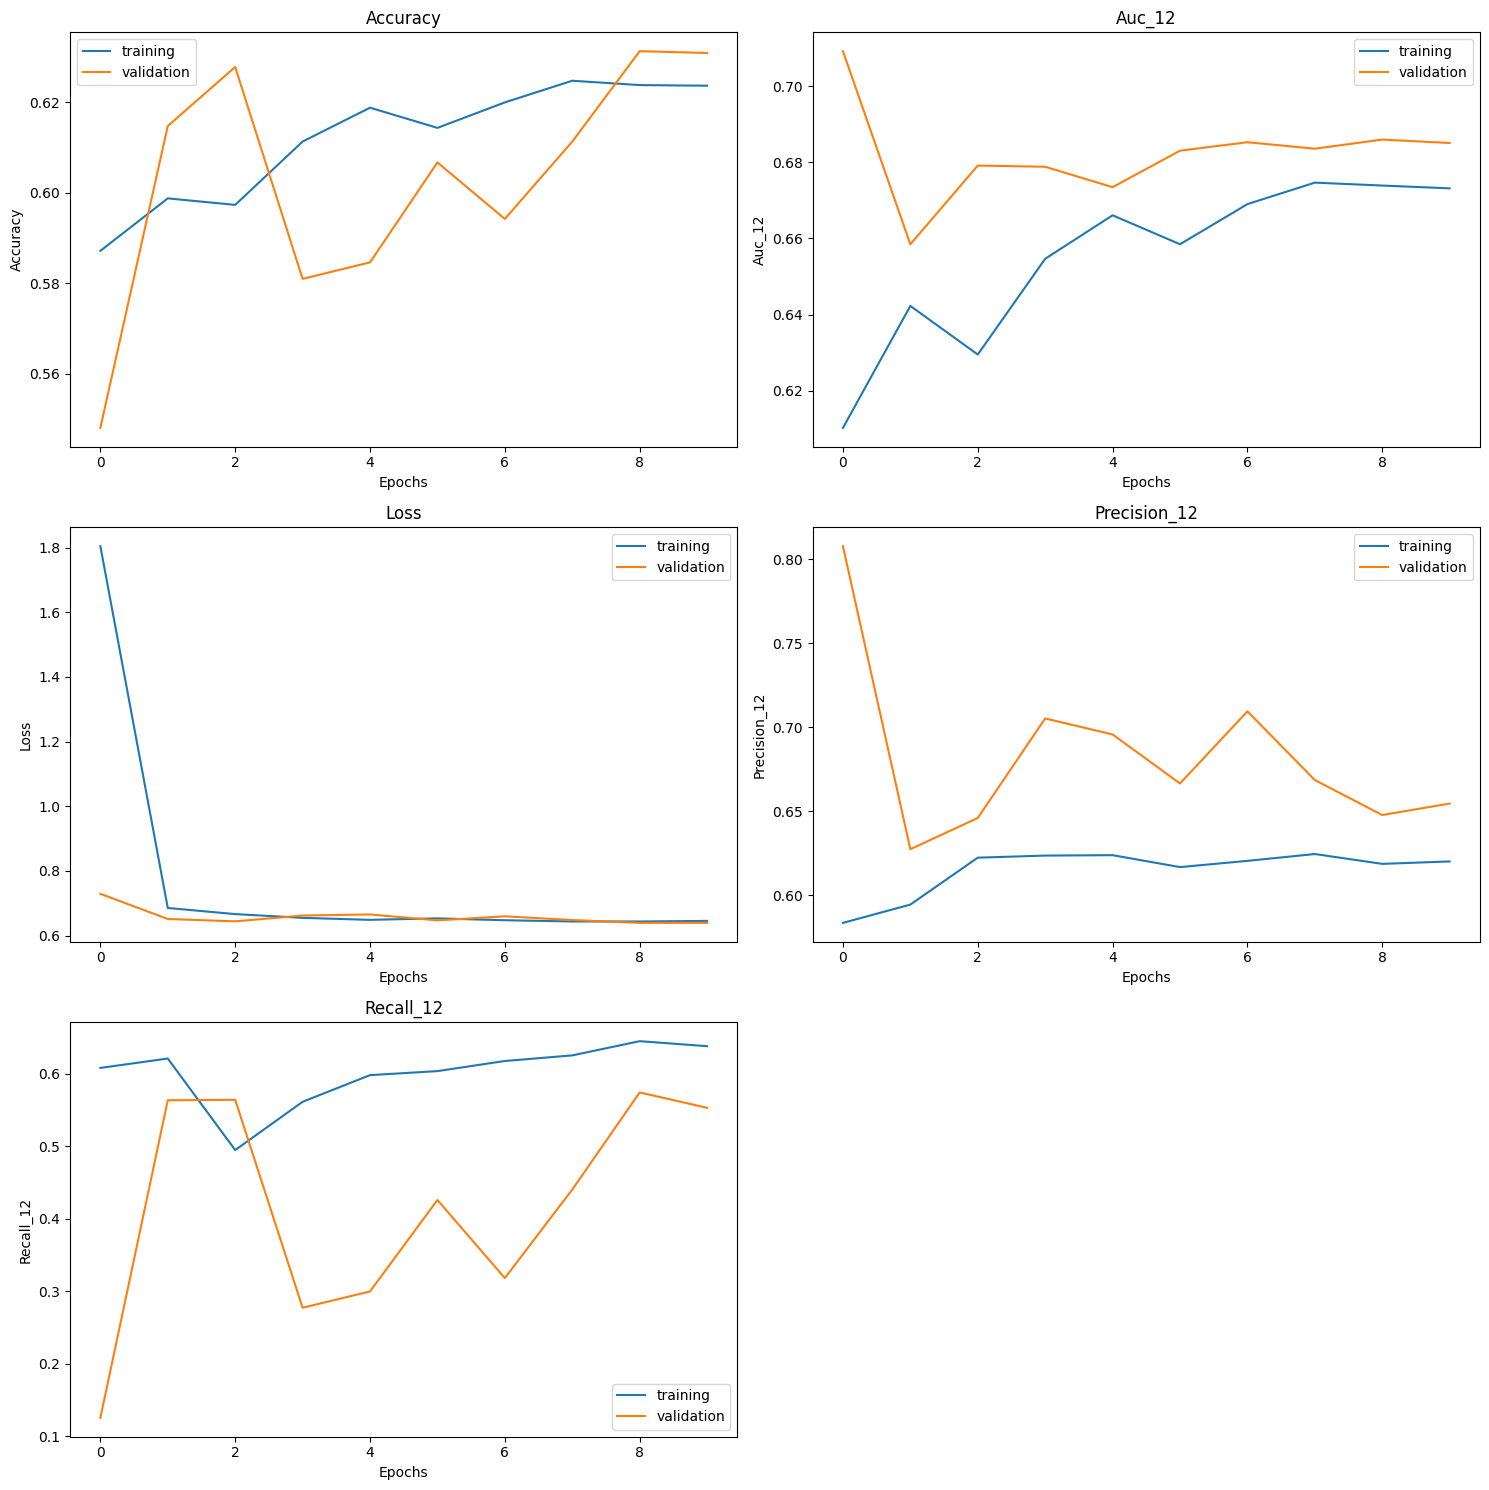

In [38]:
plot_metrics(mlp_history)

The MLP struggles to improve in performance over time, and does not generalize as well as the CNNs (shown by the closing gap between train and test AUC).

In [39]:
# mlp.save("models/mlp.keras")
# with Path.open("histories/mlp_history.pickle", "wb") as handle:
#     pickle.dump(mlp_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

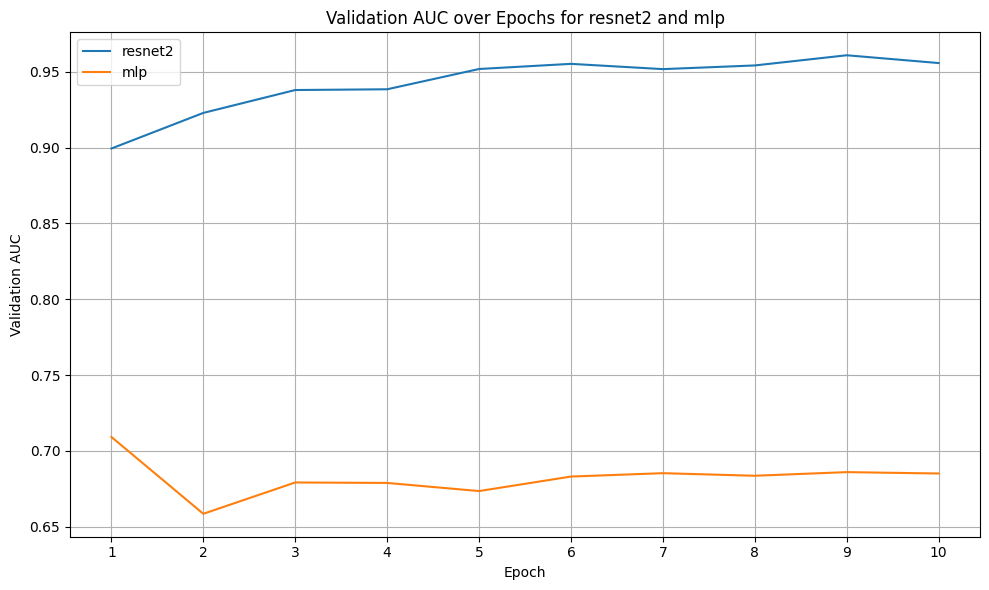

In [40]:
# Plot resnet2 validation AUC vs. mlp validation AUC
resnet2_val_auc_keys = [
    key for key in resnet2_history.history if key.startswith("val_auc")
]
mlp_val_auc_keys = [
    key for key in mlp_history.history if key.startswith("val_auc")
]

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(resnet2_history.history[resnet2_val_auc_keys[0]]) + 1),
    resnet2_history.history[resnet2_val_auc_keys[0]],
    label="resnet2",
)
plt.plot(
    range(1, len(mlp_history.history[mlp_val_auc_keys[0]]) + 1),
    mlp_history.history[mlp_val_auc_keys[0]],
    label="mlp",
)
plt.title("Validation AUC over Epochs for resnet2 and mlp")
plt.xlabel("Epoch")
plt.ylabel("Validation AUC")
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
mcnemar_test(mlp, resnet2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
McNemar's Test Results:
Statistic: 357.0
P-value: 0.0


The AUC plot and McNemar's test results tell the same story: our CNN is far superior to the MLP for this problem. The CNN is able to achieve a higher AUC and has a more gradual increase in performance over time, while the MLP struggles to improve.

## Using Transfer Learning with Pre-Trained Models

In [42]:
input_holder = Input(shape=(32, 32, 3))

# Data augmentation
x = RandomContrast(factor=0.5, seed=7324)(input_holder)
x = RandomRotation(factor=0.5, seed=7324)(x)

# Pre-trained moden
base_model = EfficientNetB0(
    input_shape=(32, 32, 3), include_top=False, weights="imagenet"
)
base_model.trainable = False

x = base_model(x)

# MLP layers
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation("sigmoid")(x)

pre_train_model = Model(inputs=input_holder, outputs=x)

pre_train_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [43]:
pre_train_history = pre_train_model.fit(
    train_img,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=test_img,
)


Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 85s 33ms/step - accuracy: 0.7050 - auc_6: 0.7734 - loss: 0.5693 - precision_6: 0.7056 - recall_6: 0.7043 - val_accuracy: 0.7952 - val_auc_6: 0.8856 - val_loss: 0.4542 - val_precision_6: 0.7598 - val_recall_6: 0.8630
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.7425 - auc_6: 0.8191 - loss: 0.5223 - precision_6: 0.7397 - recall_6: 0.7486 - val_accuracy: 0.8027 - val_auc_6: 0.8923 - val_loss: 0.4422 - val_precision_6: 0.8530 - val_recall_6: 0.7312
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 88s 35ms/step - accuracy: 0.7445 - auc_6: 0.8241 - loss: 0.5148 - precision_6: 0.7425 - recall_6: 0.7486 - val_accuracy: 0.8173 - val_auc_6: 0.8974 - val_loss: 0.4286 - val_precision_6: 0.8255 - val_recall_6: 0.8045
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 84s 34ms/step - accuracy: 0.7499 - auc_6: 0.8286 - loss: 0.5099 - precision_6: 0.7469 - recall_6: 0.7561 - val_accuracy: 0.8169 - val_auc_6: 0.9006 - val_loss: 0.4376 - val_precision_6

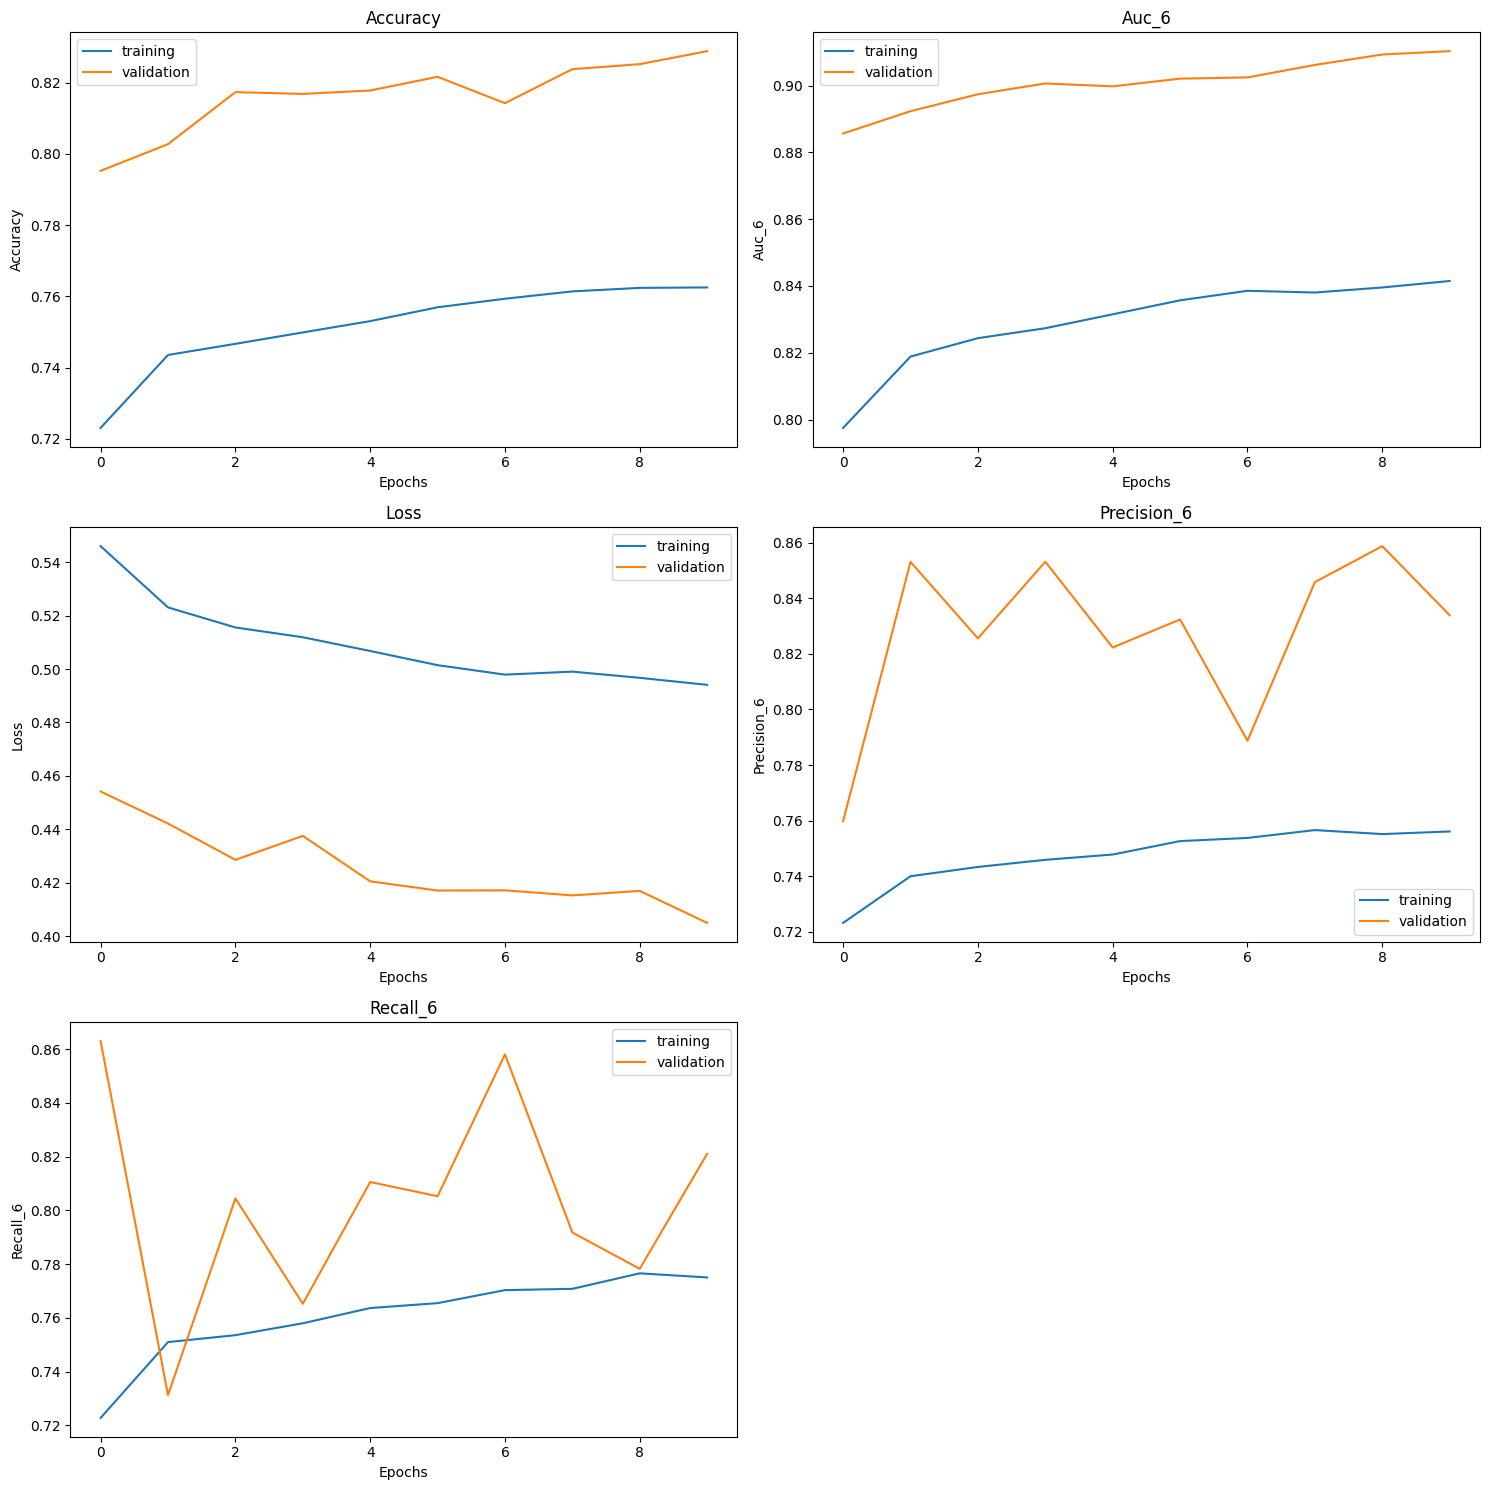

In [44]:
plot_metrics(pre_train_history)

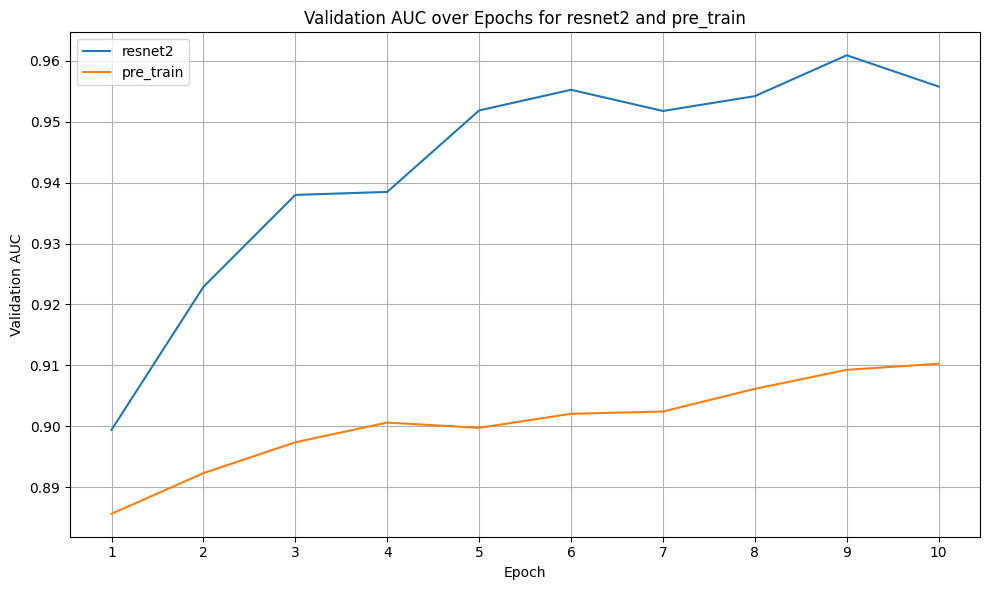

In [45]:
# Plot resnet2 validation AUC vs. pre_train validation AUC
resnet2_val_auc_keys = [
    key for key in resnet2_history.history if key.startswith("val_auc")
]
pretrain_val_auc_keys = [
    key for key in pre_train_history.history if key.startswith("val_auc")
]

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(resnet2_history.history[resnet2_val_auc_keys[0]]) + 1),
    resnet2_history.history[resnet2_val_auc_keys[0]],
    label="resnet2",
)
plt.plot(
    range(1, len(pre_train_history.history[pretrain_val_auc_keys[0]]) + 1),
    pre_train_history.history[pretrain_val_auc_keys[0]],
    label="pre_train",
)
plt.title("Validation AUC over Epochs for resnet2 and pre_train")
plt.xlabel("Epoch")
plt.ylabel("Validation AUC")
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###  Analysis

The architecture of ResNet2 (our customized best model) consists of:
- CNN(4 layers): 32 filters (2×2 kernel), 32 filters (1×1 kernel), 32 filters (2×2 kernel), and 32 filters (1×1 kernel).
- MLP(2 layers): First layer with 256 neurons,  Final output layer with 1 neuron

Compared with pre_trained model(EfficientNetB0), we can observe from the visualization above that:
- our customized model achieves a higher AUC(peaking at around 0.96), while the pre_trained model consistently performs lower, (hovering around 0.89–0.91). It shows that our customized model, even without pre-trained weights, outperforms transfer learning on our CIFAke dataset and remain highly competitive.
- The reason behind this may be that the pre-trained weights from ImageNet are not fully aligned with our dataset. And the EfficientNetB0 is usually optimized for complex ImageNet-level features(input size much larger than 32X32). However, we can explore fine-tuning strategies to improve the performance of pre_training model in the future
